# Using Traditional ML Techniques for Text Classification

## SetUp

In [1]:
# install required dependencies for text and dataframe processing
!pip install -qq wordcloud
!pip install contractions
!pip install textsearch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 35.7 MB/s 
     |████████████████████████████████| 106 kB 72.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import string

import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
#load and read data
train = pd.read_csv('https://raw.githubusercontent.com/chimaobi-okite/NLP-Projects-Competitions/main/Covid-TweetClassification/updated_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/chimaobi-okite/NLP-Projects-Competitions/main/Covid-TweetClassification/updated_test.csv')
train.head()

,ID,text,target
0,train_0,The bitcoin halving is cancelled due to,1
1,train_1,MercyOfAllah In good times wrapped in its gran...,0
2,train_2,266 Days No Digital India No Murder of e learn...,1
3,train_3,India is likely to run out of the remaining RN...,1
4,train_4,In these tough times the best way to grow is t...,0


## Expository Data Analysis

In [4]:
df = train.copy()   # create  copy of train set for analysis
print(f'The train data has a shape of {df.shape}')
print(f'The test data has a shape of {test.shape}')

The train data has a shape of (5287, 3)
The test data has a shape of (1962, 2)


In [5]:
df.isnull().sum().sum() # check for missing values in train set

0

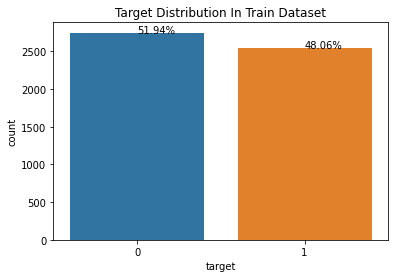

In [6]:
# is that data distriution in train set 
ax = sns.countplot(x = 'target', data = train)
for p in ax.patches:
  size = train.shape[0]
  height, width = p.get_height(), p.get_width()
  x, y = p.get_x() + width/2, p.get_y() + height
  patch_percent = '{:,.2f}%'.format((height/size)*100)
  ax.annotate(patch_percent,(x,y))


plt.title('Target Distribution In Train Dataset')
plt.show()

See word cloud presentation of words in covid related sentences and that in not-covid related sentences

In [7]:
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

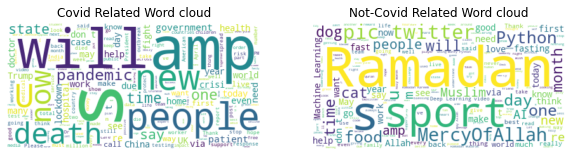

In [8]:
fig, ax = plt.subplots(1,2, figsize=(10, 10))
text1 = " ".join(i for i in df[df.target == 1].text)
text2 = " ".join(i for i in df[df.target == 0].text)
stopwords = set(STOPWORDS)
wordcloud1 = WordCloud(stopwords = stopwords, background_color="white").generate(text1)
wordcloud2 = WordCloud(stopwords= stopwords, background_color="white").generate(text2)
ax[0].imshow(wordcloud1, interpolation='bilinear')
ax[1].imshow(wordcloud2, interpolation='bilinear')
ax[0].axis("off")
ax[1].axis("off")
ax[0].set_title('Covid Related Word cloud')
ax[1].set_title('Not-Covid Related Word cloud')
plt.show()

See the distribution of words in the data

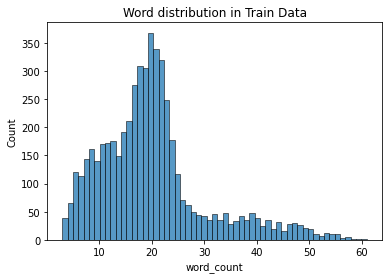

In [9]:
df['word_count'] = df['text'].apply(lambda x : len(x.split()))
sns.histplot(x = 'word_count', data = df)
plt.title('Word distribution in Train Data')
plt.show()

### Insights From EDA

1. The data distribution across the target column is balanced with 49% belonging to the positive class

2. We noticed the covid related sentences had more of words like 'people', 'pandemic', 'lockdown', 'doctor', 'hospital' etc while that of not-covid related had more of words like 'Ramadan', 'twitter', 'sports' etc. 

3. The maximum number of words in a text column is around 63 while most had between 10 - 25 words. 

## Exeriment Different Feature Extraction Techniques and Models

In [10]:
# import necessary dependencies for modelling the task
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.feature_extraction.text import CountVectorizer
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [11]:
# get data splits for training and validation.
def get_data_splits(data):
  ''' function takes a dataframe and generates train_test_splits '''
  data = data.copy()
  data.rename(columns = {'text':'tweet'}, inplace = True)
  X , y = data.drop('target', axis = 1), data['target']
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)
  return X_train, X_val, y_train, y_val

In [12]:
data = train.copy() # create copy of data for modelling

### Using Count Based Features

Lets generate count based features from text,build a model with it and see the performance 

In [13]:
def get_count_features(data, column_name):
  ''' Function generate serval count based features from the text column of a dataframe

  inputs : dataframe and a column name to get counts of.

  Returns: dataframe with wordcount, charcount, punctuationcount, worddensity,
  title_word_count,upper_case_word_count
  '''
  data = data.copy()
  data['word_count'] = data[column_name].apply(lambda x : len(x.split()))
  data['char_count'] = data[column_name].apply(lambda x : len(x))
  data['word_density'] = data['char_count'] / (data['word_count']+1)  # adding 1 to avoid zero division
  data['punctuation_count'] = data[column_name].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
  data['title_word_count'] = data[column_name].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
  data['upper_case_word_count'] = data[column_name].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

  return data


In [14]:
X_train, X_val, y_train, y_val = get_data_splits(data)
X_train = get_count_features(X_train, 'tweet')
X_val = get_count_features(X_val, 'tweet')
X_train = X_train.drop(['ID', 'tweet'], axis = 1)
X_val = X_val.drop(['ID', 'tweet'], axis = 1)
scale = StandardScaler()
scale.fit(X_train)
X_train_scale = scale.transform(X_train)
X_val_scale = scale.transform(X_val)

logit_model = LogisticRegression(random_state = 42)
logit_model.fit(X_train_scale, y_train)

LogisticRegression(random_state=42)

In [15]:
# see classification report
preds = logit_model.predict(X_val)
print(classification_report(y_val, preds))
pd.DataFrame(confusion_matrix(y_val, preds))

              precision    recall  f1-score   support

           0       0.51      1.00      0.68       542
           1       0.00      0.00      0.00       516

    accuracy                           0.51      1058
   macro avg       0.26      0.50      0.34      1058
weighted avg       0.26      0.51      0.35      1058



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being s

,0,1
0,542,0
1,516,0


#### Insight

Here we see that the model could not learn anything from the features provided. Lets try generate other features

### Text Preprocessing and Modelling 

In [16]:
nltk.download('wordnet')
nltk.download('omw-1.4')

import nltk
import contractions


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [17]:
ps = nltk.porter.PorterStemmer()   # initialize stemmer

stop_words = nltk.corpus.stopwords.words('english') # use nltk stopwords
stop_words.remove('no')
stop_words.remove('not')

def simple_text_preprocessor(document):
  document = document.lower()  # convert to lower case
  document = contractions.fix(document)  # expand contractions
  document = ' '.join([ps.stem(word) for word in document.split()])
  document = ' '.join([word for word in document.split() if word not in stop_words])

  return document

In [18]:
stp = np.vectorize(simple_text_preprocessor)

In [19]:
X_train, X_val, y_train, y_val = get_data_splits(data)
X_train['clean_tweet'] = stp(X_train['tweet'].values)
X_val['clean_tweet'] = stp(X_val['tweet'].values)
X_train.rename(columns = {'tweet': 'main_tweet'}, inplace = True)
X_val.rename(columns = {'tweet':'main_tweet'}, inplace = True)
X_train.head()

,ID,main_tweet,clean_tweet
4669,train_5957,3 7 mil was given to EcoHealth Alliance to res...,3 7 mil wa given ecohealth allianc research pr...
3885,train_4843,This one is also prophetic Vsauce Elon Musk an...,thi one also prophet vsauc elon musk respons l...
318,train_332,Silence is golden for whales as lockdown reduc...,silenc golden whale lockdown reduc ocean nois
274,train_285,deaths per million India has outperformed Ital...,death per million india ha outperform itali 44...
4560,train_5794,Don t worry you re the only cat a pulte I know,worri onli cat pult know


In [20]:
# Use count vectorizer to get n_gram features from texts
cv = CountVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1, 1))
cv.fit(X_train['clean_tweet'])
X_traincv = cv.transform(X_train['clean_tweet']).toarray()
X_traincv = pd.DataFrame(X_traincv, columns=cv.get_feature_names())

X_valcv = cv.transform(X_val['clean_tweet']).toarray()
X_valcv = pd.DataFrame(X_valcv, columns=cv.get_feature_names())
X_traincv.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,00,000,000won,0016,002,0079586808,00pm,01,015,01603,...,zetimi,zheng,zimbabw,zindi,zine,zone,zoom,zrouf,zudo,zw
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# combine count based features with the n-gram features
X_train_comb = pd.concat([X_train.reset_index(drop=True), X_traincv.reset_index(drop=True)], axis=1)
X_val_comb = pd.concat([X_val.reset_index(drop=True), X_valcv.reset_index(drop=True)], axis=1)

X_train_comb.head()

,ID,main_tweet,clean_tweet,00,000,000won,0016,002,0079586808,00pm,...,zetimi,zheng,zimbabw,zindi,zine,zone,zoom,zrouf,zudo,zw
0,train_5957,3 7 mil was given to EcoHealth Alliance to res...,3 7 mil wa given ecohealth allianc research pr...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,train_4843,This one is also prophetic Vsauce Elon Musk an...,thi one also prophet vsauc elon musk respons l...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,train_332,Silence is golden for whales as lockdown reduc...,silenc golden whale lockdown reduc ocean nois,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,train_285,deaths per million India has outperformed Ital...,death per million india ha outperform itali 44...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,train_5794,Don t worry you re the only cat a pulte I know,worri onli cat pult know,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
# final postprocessing before mmodelling
X_train = get_count_features(X_train_comb, 'main_tweet')
X_val = get_count_features(X_val_comb, 'main_tweet')
X_train = X_train.drop(['ID', 'main_tweet', 'clean_tweet'], axis = 1)
X_val = X_val.drop(['ID', 'main_tweet', 'clean_tweet'], axis = 1)
scale = StandardScaler()
X_train_scale = scale.fit_transform(X_train)
X_val_scale = scale.fit_transform(X_val)

#### Build Logistics regression model

In [23]:
logit_model = LogisticRegression(random_state = 42, max_iter=3000)
logit_model.fit(X_train_scale, y_train)

LogisticRegression(max_iter=3000, random_state=42)

In [24]:
preds = logit_model.predict(X_val_scale)
print(classification_report(y_val, preds))
print(f'accuracy : {accuracy_score(preds, y_val)}')
pd.DataFrame(confusion_matrix(y_val, preds))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       542
           1       0.87      0.83      0.85       516

    accuracy                           0.86      1058
   macro avg       0.86      0.85      0.86      1058
weighted avg       0.86      0.86      0.86      1058

accuracy : 0.8553875236294896


,0,1
0,477,65
1,88,428


#### Build Xgboost Model

In [25]:
xgmodel = XGBClassifier(random_state = 42, max_depth = 10)
xgmodel.fit(X_train_scale, y_train)

XGBClassifier(max_depth=10, random_state=42)

In [26]:
preds = xgmodel.predict(X_val_scale)
print(classification_report(y_val, preds))
print(f'accuracy : {accuracy_score(preds, y_val)}')
pd.DataFrame(confusion_matrix(y_val, preds))

              precision    recall  f1-score   support

           0       0.97      0.79      0.87       542
           1       0.81      0.97      0.89       516

    accuracy                           0.88      1058
   macro avg       0.89      0.88      0.88      1058
weighted avg       0.89      0.88      0.88      1058

accuracy : 0.8771266540642723


,0,1
0,427,115
1,15,501


#### Build LGBM Model

In [27]:
lgb_model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
lgb_model.fit(X_train_scale,y_train,eval_set=[(X_val_scale,y_val),(X_train_scale,y_train)],
          verbose=20,eval_metric='logloss')

[20]	training's binary_logloss: 0.291578	training's binary_logloss: 0.291578	valid_0's binary_logloss: 0.338341	valid_0's binary_logloss: 0.338341
[40]	training's binary_logloss: 0.21879	training's binary_logloss: 0.21879	valid_0's binary_logloss: 0.284737	valid_0's binary_logloss: 0.284737
[60]	training's binary_logloss: 0.18429	training's binary_logloss: 0.18429	valid_0's binary_logloss: 0.268187	valid_0's binary_logloss: 0.268187
[80]	training's binary_logloss: 0.15979	training's binary_logloss: 0.15979	valid_0's binary_logloss: 0.261066	valid_0's binary_logloss: 0.261066
[100]	training's binary_logloss: 0.140443	training's binary_logloss: 0.140443	valid_0's binary_logloss: 0.260587	valid_0's binary_logloss: 0.260587


LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)

In [28]:
preds = lgb_model.predict(X_val_scale)
print(classification_report(y_val, preds))
print(f'accuracy : {accuracy_score(preds, y_val)}')
pd.DataFrame(confusion_matrix(y_val, preds))

              precision    recall  f1-score   support

           0       0.95      0.81      0.88       542
           1       0.83      0.96      0.89       516

    accuracy                           0.88      1058
   macro avg       0.89      0.88      0.88      1058
weighted avg       0.89      0.88      0.88      1058

accuracy : 0.8818525519848771


,0,1
0,439,103
1,22,494


#### Build An Ensemble Model

In [29]:
estimators = [('xgb',xgmodel),('lgb',lgb_model), ('log', logit_model)]
stc_ensemble = StackingClassifier(estimators,XGBClassifier(seed = 42))
stc_ensemble.fit(X_train_scale,y_train)

StackingClassifier(estimators=[('xgb',
                                XGBClassifier(max_depth=10, random_state=42)),
                               ('lgb',
                                LGBMClassifier(learning_rate=0.09, max_depth=-5,
                                               random_state=42)),
                               ('log',
                                LogisticRegression(max_iter=3000,
                                                   random_state=42))],
                   final_estimator=XGBClassifier(seed=42))

In [30]:
preds = stc_ensemble.predict(X_val_scale)
print(classification_report(y_val, preds))
print(f'accuracy : {accuracy_score(preds, y_val)}')
pd.DataFrame(confusion_matrix(y_val, preds))

              precision    recall  f1-score   support

           0       0.93      0.86      0.89       542
           1       0.86      0.93      0.90       516

    accuracy                           0.89      1058
   macro avg       0.90      0.89      0.89      1058
weighted avg       0.90      0.89      0.89      1058

accuracy : 0.8941398865784499


,0,1
0,467,75
1,37,479


### Insights from Experiment 

1. using count based features alone had no impact on any of the models
2. The final processing steps used above where gotten by iteratively using trail and error method. Like lemmantization instead of stemming gave poor results, including 'not'/'no' in the stop words decreased performance drastically etc.
3. The models could'nt learn anything when I tried using 2_gram bag of words and had a performance decline with TF_IDF model
4. Stacking ensemble had the best performance though the training took lots of time. For competition purposes, it will be best to submit while for production, The LightGB model is the go-to.

## Final Processing

Modularize text preprocessing and apply it to both train and test sets

In [54]:

def process(data, is_test = False):

  '''
  Function to process a dataframe
  '''
  data = data.copy()
  data.rename(columns = {'text':'tweet'}, inplace = True)
  data['clean_tweet'] = stp(data['tweet'].values)
  data.rename(columns = {'tweet': 'main_tweet', 'target':'main_target'}, inplace = True)
  if not is_test:
    print('train')
    cv.fit(data['clean_tweet'])
  datacv = cv.transform(data['clean_tweet']).toarray()
  datacv = pd.DataFrame(datacv, columns=cv.get_feature_names())
  data_comb = pd.concat([data.reset_index(drop=True), datacv.reset_index(drop=True)], axis=1)
  data = get_count_features(data_comb, 'main_tweet')
  return data


In [55]:
train_df = process(train)
test_df = process(test, is_test = True)

train


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [56]:
X , y = train_df.drop('main_target', axis = 1), train_df['main_target']
X = X.drop(['ID', 'main_tweet', 'clean_tweet'], axis = 1)

# split to ensure everything is working fine
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)
scale = StandardScaler()
scale.fit(X_train)
X_train_scale = scale.transform(X_train)
X_val_scale = scale.transform(X_val)

In [57]:
# test with the lgb_model
lgb_model.fit(X_train_scale,y_train,eval_set=[(X_val_scale,y_val),(X_train_scale,y_train)],
          verbose=20,eval_metric='logloss')

[20]	training's binary_logloss: 0.291578	training's binary_logloss: 0.291578	valid_0's binary_logloss: 0.338139	valid_0's binary_logloss: 0.338139
[40]	training's binary_logloss: 0.21879	training's binary_logloss: 0.21879	valid_0's binary_logloss: 0.284434	valid_0's binary_logloss: 0.284434
[60]	training's binary_logloss: 0.18429	training's binary_logloss: 0.18429	valid_0's binary_logloss: 0.267708	valid_0's binary_logloss: 0.267708
[80]	training's binary_logloss: 0.15979	training's binary_logloss: 0.15979	valid_0's binary_logloss: 0.261432	valid_0's binary_logloss: 0.261432
[100]	training's binary_logloss: 0.140443	training's binary_logloss: 0.140443	valid_0's binary_logloss: 0.26131	valid_0's binary_logloss: 0.26131


LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)

In [58]:
# verify performance
preds = lgb_model.predict(X_val_scale)
print(classification_report(y_val, preds))
print(f'accuracy : {accuracy_score(preds, y_val)}')
pd.DataFrame(confusion_matrix(y_val, preds))

              precision    recall  f1-score   support

           0       0.94      0.81      0.87       542
           1       0.82      0.95      0.88       516

    accuracy                           0.88      1058
   macro avg       0.88      0.88      0.88      1058
weighted avg       0.89      0.88      0.88      1058

accuracy : 0.8761814744801513


,0,1
0,437,105
1,26,490


## Making Prediction On Test Set

In [59]:
# process test
X_test = test_df.drop(['ID', 'main_tweet', 'clean_tweet'], axis = 1)
X_test_scale = scale.transform(X_test)

In [61]:
# use all train data
scale = StandardScaler()
scale.fit(X)
X_scale = scale.transform(X)

### With LIGHTGB Model

In [62]:
lgb_model.fit(X_scale,y)
pred = lgb_model.predict_proba(X_test_scale)
sub_df = pd.DataFrame({'ID': test_df.ID, 'target':pred[:, 1]})
sub_df.to_csv('submission_tml2', index = False)

### With Stacking Ensemble

In [63]:
stc_ensemble.fit(X_scale,y)
pred = lgb_model.predict_proba(X_test_scale)
sub_df = pd.DataFrame({'ID': test_df.ID, 'target':pred[:, 1]})
sub_df.to_csv('submission_tml3', index = False)